<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/IA353/EF2/Q7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using innvestigate to interpreting deep neural networks
# Samuel Borges Ferreira Gomes
# Prof. Fernando J. Von Zuben
# FEEC/UNICAMP - June/2021

# Based on https://github.com/albermax/innvestigate

In [1]:
!pip install innvestigate
!pip install scipy==1.1.0
!pip install git+https://github.com/raghakot/keras-vis.git -U

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-b_g7goei
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-b_g7goei
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38900 sha256=bf38783534ce44fa1369912370cefa5057183ad2113cce830ef4ce600f628442
  Stored in directory: /tmp/pip-ephem-wheel-cache-74_di7eo/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.5.0
    Uninstalling keras-vis-0.5.0:
      Successfully uninstalled keras-vis-0.5.0


In [2]:
pip install h5py==2.10.0

### Imports

In [3]:
%tensorflow_version 1.x 

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import innvestigate
import keras
from keras import backend as K
from vis.visualization import visualize_activation
from vis.utils import utils

TensorFlow 1.x selected.


Using TensorFlow backend.


### Download MNIST

In [4]:
mnist = keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

### Model

In [5]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(28, 28, 1)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



### Training

In [6]:
model.get_config()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size=64)


Epoch 1/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.2085 - accuracy: 0.9360
Epoch 2/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.0811 - accuracy: 0.9758
Epoch 3/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.0616 - accuracy: 0.9809
Epoch 4/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.0499 - accuracy: 0.9848
Epoch 5/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.0437 - accuracy: 0.9861


### Evaluation

In [7]:
evaluation = model.evaluate(x_test, y_test)

model.save('mnist_model.h5')

10000/10000 [==============================] - 1s 62us/step


In [8]:
x_test.shape

(10000, 28, 28, 1)

Data sample:

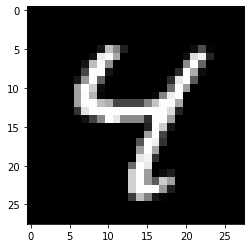

In [9]:
model = keras.models.load_model('mnist_model.h5')

model_wo_sm = innvestigate.utils.model_wo_softmax(model)
ex=6
imagem = x_test[ex:ex+1]
plt.imshow(imagem.squeeze(), cmap='gray', interpolation='nearest')

## Gradient, SmoothGradient, DeepTaylor, LRPAlphaBeta, LRPEpsilon, LRPZ methods

In [10]:
from __future__ import absolute_import, division, print_function, unicode_literals

# catch exception with: except Exception as e
from builtins import filter, map, range, zip
from io import open

import keras
import numpy as np
import six
from future.utils import raise_from, raise_with_traceback
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Activation, Dense, Dropout, Input
from keras.models import Model
from keras.optimizers import Adam

import innvestigate
import innvestigate.applications.mnist
import innvestigate.utils
import innvestigate.utils as iutils
import innvestigate.utils.tests
import innvestigate.utils.tests.networks
import innvestigate.utils.visualizations as ivis

# End: Python 2/3 compatability header small


###############################################################################
###############################################################################
###############################################################################


###############################################################################
# Data Preprocessing Utility
###############################################################################


def fetch_data():
    channels_first = K.image_data_format() == "channels_first"
    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if channels_first:
        x_train = x_train.reshape(60000, 1, 28, 28)
        x_test = x_test.reshape(10000, 1, 28, 28)
    else:
        x_train = x_train.reshape(60000, 28, 28, 1)
        x_test = x_test.reshape(10000, 28, 28, 1)

    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")

    return x_train, y_train, x_test, y_test


def create_preprocessing_f(X, input_range=[0, 1]):
    """
    Generically shifts data from interval [a, b] to interval [c, d].
    Assumes that theoretical min and max values are populated.
    """

    if len(input_range) != 2:
        raise ValueError(
            "Input range must be of length 2, but was {}".format(len(input_range))
        )
    if input_range[0] >= input_range[1]:
        raise ValueError(
            "Values in input_range must be ascending. It is {}".format(input_range)
        )

    a, b = X.min(), X.max()
    c, d = input_range

    def preprocessing(X):
        # shift original data to [0, b-a] (and copy)
        X = X - a
        # scale to new range gap [0, d-c]
        X /= b - a
        X *= d - c
        # shift to desired output range
        X += c
        return X

    def revert_preprocessing(X):
        X = X - c
        X /= d - c
        X *= b - a
        X += a
        return X

    return preprocessing, revert_preprocessing


############################
# Model Utility
############################


def create_model(modelname, **kwargs):
    channels_first = K.image_data_format() == "channels_first"
    num_classes = 10

    if channels_first:
        input_shape = (None, 1, 28, 28)
    else:
        input_shape = (None, 28, 28, 1)

    # load PreTrained models
    if modelname in innvestigate.applications.mnist.__all__:
        model_init_fxn = getattr(innvestigate.applications.mnist, modelname)
        model_wo_sm, model_w_sm = model_init_fxn(input_shape[1:])

    elif modelname in innvestigate.utils.tests.networks.base.__all__:
        network_init_fxn = getattr(innvestigate.utils.tests.networks.base, modelname)
        network = network_init_fxn(input_shape, num_classes, **kwargs)
        model_wo_sm = Model(inputs=network["in"], outputs=network["out"])
        model_w_sm = Model(inputs=network["in"], outputs=network["sm_out"])
    else:
        raise ValueError("Invalid model name {}".format(modelname))

    return model_w_sm


def train_model(model, data, batch_size=128, epochs=20):
    num_classes = 10

    x_train, y_train, x_test, y_test = data
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model.compile(
        loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"]
    )

    history = model.fit(
        x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1
    )
    score = model.evaluate(x_test, y_test, verbose=0)
    return score


############################
# Post Processing Utility
############################


def postprocess(X):
    X = X.copy()
    X = iutils.postprocess_images(X)
    return X


def bk_proj(X):
    return ivis.graymap(X)


def heatmap(X):
    return ivis.heatmap(X)


def graymap(X):
    return ivis.graymap(np.abs(X), input_is_positive_only=True)

In [11]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = fetch_data()

In [12]:
# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

In [13]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   graymap,        "Gradient"),
    ("smoothgrad",            {"noise_scale": noise_scale,
                               "postprocess": "square"},graymap,        "SmoothGrad"),

    # Interaction
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, heatmap,        "DeepTaylor"),
    ("lrp.alpha_beta",  {"alpha": 1, "beta": 0}, heatmap,        "LRP AlphaBeta"),
    ("lrp.epsilon",           {"epsilon": 1},           heatmap,        "LRP-Epsilon"),
    ("lrp.z",                 {},                       heatmap,        "LRP-Z"),
    
]

In [14]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

In [15]:
%%capture

n = 6
# test_images = list(zip(data[2][:n], data[3][:n]))
I = np.stack((data[2][2],data[2][5],data[2][4],data[2][6],data[2][7],data[2][9]))
J = np.stack((data[3][2],data[3][5],data[3][4],data[3][6],data[3][7],data[3][9]))
test_images = list(zip(I,J))

analysis = np.zeros([len(test_images), len(analyzers), 28, 28, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import shutil

# catch exception with: except Exception as e
from builtins import filter, map, range, zip
from io import open

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import six
from future.utils import raise_from, raise_with_traceback

# End: Python 2/3 compatability header small


###############################################################################
# Download utilities
###############################################################################


def download(url, filename):
    if not os.path.exists(filename):
        print("Download: %s ---> %s" % (url, filename))
        response = six.moves.urllib.request.urlopen(url)
        with open(filename, "wb") as out_file:
            shutil.copyfileobj(response, out_file)


###############################################################################
# Plot utility
###############################################################################


def load_image(path, size):
    ret = PIL.Image.open(path)
    ret = ret.resize((size, size))
    ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
    if ret.ndim == 2:
        # Convert gray scale image to color channels.
        ret.resize((size, size, 1))
        ret = np.repeat(ret, 3, axis=-1)
    return ret


def get_imagenet_data(size=224):
    base_dir = os.path.dirname(__file__)

    # ImageNet 2012 validation set images?
    with open(os.path.join(base_dir, "images", "ground_truth_val2012")) as f:
        ground_truth_val2012 = {
            x.split()[0]: int(x.split()[1]) for x in f.readlines() if len(x.strip()) > 0
        }
    with open(os.path.join(base_dir, "images", "synset_id_to_class")) as f:
        synset_to_class = {
            x.split()[1]: int(x.split()[0]) for x in f.readlines() if len(x.strip()) > 0
        }
    with open(os.path.join(base_dir, "images", "imagenet_label_mapping")) as f:
        image_label_mapping = {
            int(x.split(":")[0]): x.split(":")[1].strip()
            for x in f.readlines()
            if len(x.strip()) > 0
        }

    def get_class(f):
        # File from ImageNet 2012 validation set
        ret = ground_truth_val2012.get(f, None)
        if ret is None:
            # File from ImageNet training sets
            ret = synset_to_class.get(f.split("_")[0], None)
        if ret is None:
            # Random JPEG file
            ret = "--"
        return ret

    images = [
        (load_image(os.path.join(base_dir, "images", f), size), get_class(f))
        for f in os.listdir(os.path.join(base_dir, "images"))
        if (f.lower().endswith(".jpg") or f.lower().endswith(".jpeg"))
        and get_class(f) != "--"
    ]
    return images, image_label_mapping


def plot_image_grid(
    grid,
    row_labels_left,
    row_labels_right,
    col_labels,
    file_name=None,
    figsize=None,
    dpi=224,
):
    n_rows = len(grid)
    n_cols = len(grid[0])
    if figsize is None:
        figsize = (n_cols, n_rows + 1)

    plt.clf()
    plt.rc("font", family="sans-serif")

    plt.figure(figsize=figsize)
    for r in range(n_rows):
        for c in range(n_cols):
            ax = plt.subplot2grid(shape=[n_rows + 1, n_cols], loc=[r + 1, c])
            # No border around subplots
            for spine in ax.spines.values():
                spine.set_visible(False)
            # TODO controlled color mapping wrt all grid entries,
            # or individually. make input param
            if grid[r][c] is not None:
                ax.imshow(grid[r][c], interpolation="none")
            else:
                for spine in plt.gca().spines.values():
                    spine.set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

            # column labels
            if not r:
                if col_labels != []:
                    ax.set_title(
                        col_labels[c],
                        rotation=22.5,
                        horizontalalignment="left",
                        verticalalignment="bottom",
                    )

            # row labels
            if not c:
                if row_labels_left != []:
                    txt_left = [l + "\n" for l in row_labels_left[r]]
                    ax.set_ylabel(
                        "".join(txt_left),
                        rotation=0,
                        verticalalignment="center",
                        horizontalalignment="right",
                    )

            if c == n_cols - 1:
                if row_labels_right != []:
                    txt_right = [l + "\n" for l in row_labels_right[r]]
                    ax2 = ax.twinx()
                    # No border around subplots
                    for spine in ax2.spines.values():
                        spine.set_visible(False)
                    ax2.set_xticks([])
                    ax2.set_yticks([])
                    ax2.set_ylabel(
                        "".join(txt_right),
                        rotation=0,
                        verticalalignment="center",
                        horizontalalignment="left",
                    )

    if file_name is None:
        plt.show()
    else:
        print("Saving figure to {}".format(file_name))
        plt.savefig(file_name, orientation="landscape", dpi=dpi, bbox_inches="tight")
        plt.show()

<Figure size 432x288 with 0 Axes>

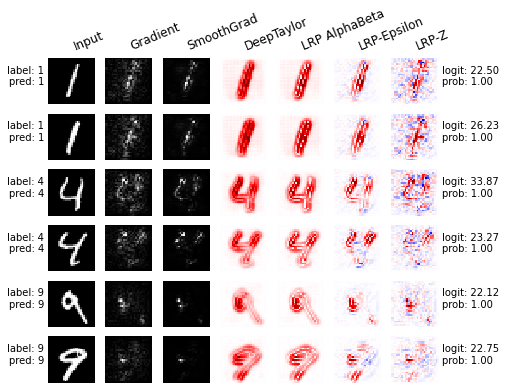

In [17]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("PLOTFILENAME", None))

We see two examples of three distinct classes 1, 4 and 9. We can see that DeepTaylor and LRP AlphaBeta are clearly visible indicating where the neural network focus its attention to differentiate each digit.

After several tries, I choose the epsilon parameter of LRP-Epsilon set to 1 and Alpha=1, Beta=0 of LRP AlphaBeta, due to it was the parameters that allowed a better visualization.

# Interpretation of the neural network predictions for each of 10 classes

In [18]:
model = keras.models.load_model('mnist_model.h5')

layer_idx = utils.find_layer_idx(model, 'dense_2')
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

filter_idx = 9
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True, max_iter=1000, tv_weight=10., lp_norm_weight=10.)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iteration: 1, named_losses: [('ActivationMax Loss', 0.5474234),
 ('L-6.0 Norm Loss', 0.019834844),
 ('TV(2.0) Loss', 0.0941799)], overall loss: 0.6614381074905396
Iteration: 2, named_losses: [('ActivationMax Loss', -15.610912),
 ('L-6.0 Norm Loss', 0.17221466),
 ('TV(2.0) Loss', 496.56253)], overall loss: 481.12384033203125
Iteration: 3, named_losses: [('ActivationMax Loss', -146.89943),
 ('L-6.0 Norm Loss', 0.1812256),
 ('TV(2.0) Loss', 158.34988)], overall loss: 11.631683349609375
Iteration: 4, named_losses: [('ActivationMax Loss', -275.8592),
 ('L-6.0 Norm Loss', 0.20922074),
 ('TV(2.0) Loss', 193.96388)], overall loss: -81.68608093261719
Iteration: 5, named_losses: [('ActivationMax Loss', -395.8924),
 ('L-6.0 Norm Loss', 0.22313808),
 ('TV(2.0) Loss', 200.44073)], overall loss: -195.228515625
Iteration: 6, named_losses: [('ActivationMax Loss', -524.5613),
 ('L-6.0 Norm Loss', 0.24747947),


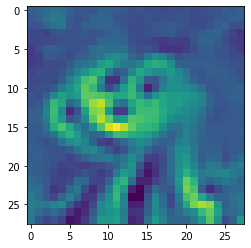

In [19]:
plt.imshow(img[..., 0])

We can see that ActivationMax Loss is bouncing around towards convergence. We should try to get that loss to be lower by reducing weights of other losses that might be dominating the overall loss being minimized

Setting weights to be 0. for all regularization losses:

Iteration: 1, named_losses: [('ActivationMax Loss', 0.8031901)], overall loss: 0.8031901121139526
Iteration: 2, named_losses: [('ActivationMax Loss', -24.852072)], overall loss: -24.85207176208496
Iteration: 3, named_losses: [('ActivationMax Loss', -250.67018)], overall loss: -250.67018127441406
Iteration: 4, named_losses: [('ActivationMax Loss', -536.9019)], overall loss: -536.9019165039062
Iteration: 5, named_losses: [('ActivationMax Loss', -775.54517)], overall loss: -775.545166015625
Iteration: 6, named_losses: [('ActivationMax Loss', -1013.09467)], overall loss: -1013.0946655273438
Iteration: 7, named_losses: [('ActivationMax Loss', -1253.7335)], overall loss: -1253.7335205078125
Iteration: 8, named_losses: [('ActivationMax Loss', -1470.1256)], overall loss: -1470.1256103515625
Iteration: 9, named_losses: [('ActivationMax Loss', -1677.8407)], overall loss: -1677.8406982421875
Iteration: 10, named_losses: [('ActivationMax Loss', -1875.9838)], overall loss: -1875.9837646484375
Itera

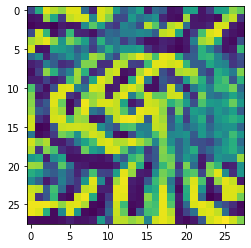

In [20]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                           tv_weight=0., lp_norm_weight=0., verbose=True)
plt.imshow(img[..., 0])

## Tuning Total variation weights

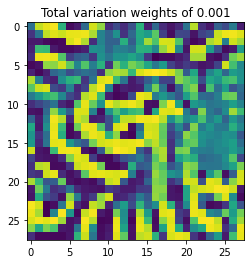

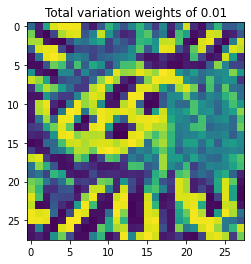

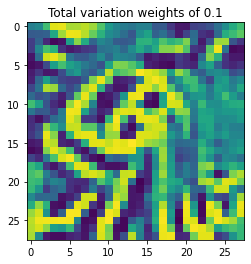

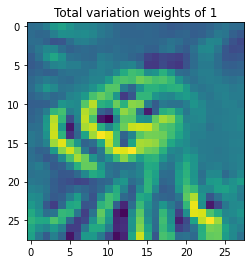

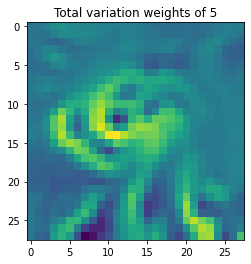

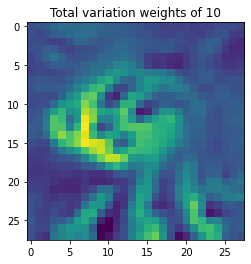

In [21]:
for tv_weight in [1e-3, 1e-2, 1e-1, 1, 5, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=tv_weight, lp_norm_weight=0.)
    plt.figure()
    plt.title('Total variation weights of {}'.format(tv_weight))
    plt.imshow(img[..., 0])

## Tuning Lp norm weights

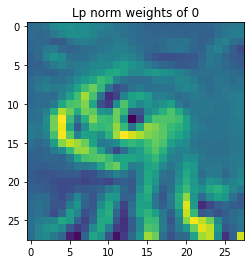

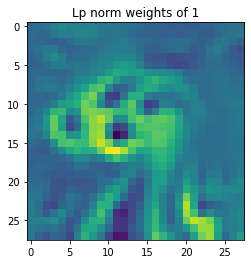

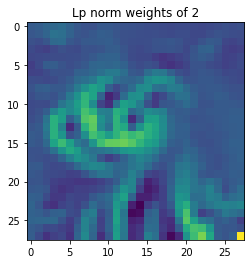

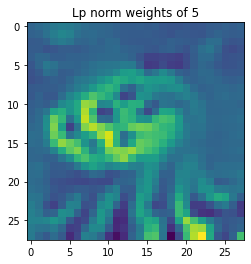

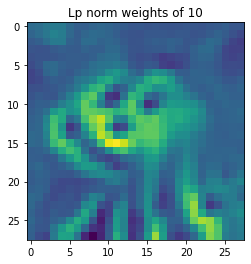

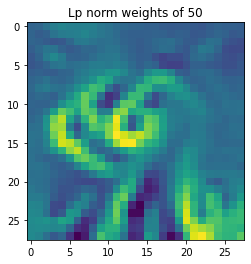

In [22]:
for lp_norm_weight in [0, 1, 2, 5, 10, 50]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=5, lp_norm_weight=lp_norm_weight)
    plt.figure()
    plt.title('Lp norm weights of {}'.format(lp_norm_weight))
    plt.imshow(img[..., 0])

## Network perception for each digit

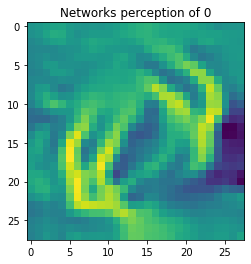

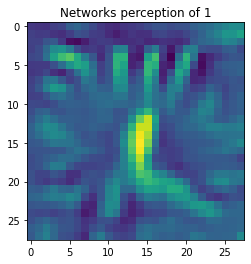

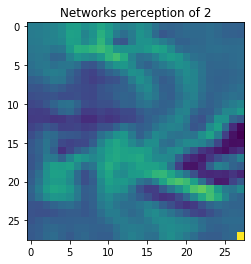

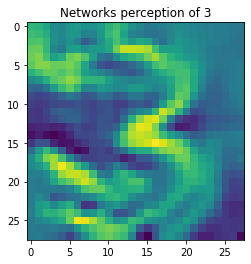

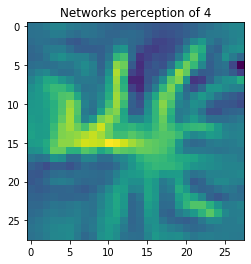

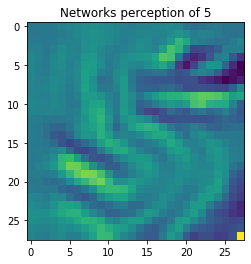

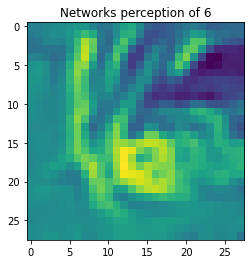

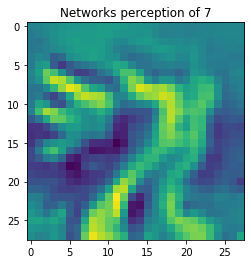

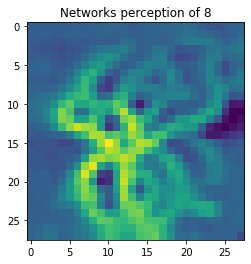

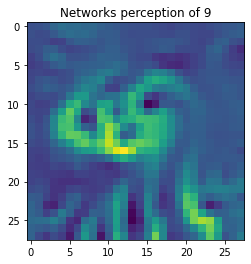

In [23]:
for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.),
                               tv_weight=5, lp_norm_weight=5)
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

Indeed, after tunning regularizations parameters, the activationi for each class is pretty visible. We can use this result to backpropagate through the model and generate new samples.